In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from scipy.linalg import pascal
from scipy.stats import norm

In [2]:
from faure_seq import get_faure_seq
from sobol_seq import get_sobol_seq

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [75]:
def discrepancy(sequence):
    min_index_0 = np.argmin(sequence[0])
    min_index_1 = np.argmin(sequence[1])

    vol_0 = sequence[0][min_index_0] * sequence[1][min_index_0]
    vol_1 = sequence[0][min_index_1] * sequence[1][min_index_1]

    vol_A = max(vol_0, vol_1)
    sup = abs(vol_A - 1 / len(sequence[0]))
    return sup

In [4]:
def BSM_payoff(S):
    global strike
    if S > strike:
        return S - strike
    return 0

In [5]:
def BSM_two_methods(S, r, sigma, T, dt):
    z = np.random.normal(0, np.sqrt(dt))
    return r * S * dt + sigma * S * z, S * np.exp((r - (sigma ** 2) / 2) * T + sigma * np.sqrt(T) * z)

In [6]:
def BS_exact(S_0, sigma, T, r, K):
    d_plus = norm.cdf((np.log(S_0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))) 
    d_minus = norm.cdf((np.log(S_0 / K) + (r - (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T)))
    return S_0 * d_plus - np.exp(-r * T) * K * d_minus

In [7]:
def BSM_quasi(S, r, sigma, dt, random_values):
    return r * S * dt + sigma * S * dt * norm.ppf(random_values), S * np.exp((r - (sigma ** 2) / 2) * dt + sigma * np.sqrt(dt)* norm.ppf(random_values))

In [58]:
count_of_dimension = 10
count_of_values = 13
s_faure = get_faure_seq(count_of_dimension, 2 ** count_of_values - 1, 3)
s_sobol = get_sobol_seq(count_of_dimension, count_of_values)

S_0, r, sigma, T = 20, 0.1, 0.1, 1
strike, N = 20, 2 ** count_of_values - 1
ans = np.mean([np.vectorize(BSM_payoff)
               (np.array([S_0 + BSM_two_methods(S_0, r, sigma, T, T)[0], 
                          BSM_two_methods(S_0, r, sigma, T, T)[1]]))  for i in range(N)], axis=0) * np.exp(-r * T)


numerical_quasi_sobol = np.mean(np.vectorize(BSM_payoff)([S_0 + BSM_quasi(S_0, r, sigma, T, i)[0] for i in s_sobol[0]])) * np.exp(-r * T)
analytical_quasi_sobol = np.mean(np.vectorize(BSM_payoff)([BSM_quasi(S_0, r, sigma, T, i)[1] for i in s_sobol[0]])) * np.exp(-r * T)

numerical_quasi_faure = np.mean(np.vectorize(BSM_payoff)([S_0 + BSM_quasi(S_0, r, sigma, T, i)[0] for i in s_faure[0]])) * np.exp(-r * T)
analytical_quasi_faure = np.mean(np.vectorize(BSM_payoff)([BSM_quasi(S_0, r, sigma, T, i)[1] for i in s_faure[0]])) * np.exp(-r * T)

stats = pd.DataFrame(data={'monte_carlo': [ans[0], ans[1]], 
                    'quasi_faure': [numerical_quasi_faure, analytical_quasi_faure], 
                    'quasi_sobol': [numerical_quasi_sobol, analytical_quasi_sobol]}, index=['numerical', 'analutical'])


print('exact solution:', BS_exact(S_0, sigma, T, r, strike))
stats

exact solution: 2.0616301851268855


,monte_carlo,quasi_faure,quasi_sobol
numerical,1.937828,1.958433,1.960123
analutical,2.008555,2.059129,2.061154


In [49]:
count_of_dimension = 4
count_of_values = 14
s_faure = get_faure_seq(count_of_dimension, 2 ** count_of_values - 1, 3)
s_sobol = get_sobol_seq(count_of_dimension, count_of_values)

S_0, r, sigma, T = 20, 0.1, 0.1, 1
strike, N = 20, 2 ** count_of_values - 1


100%|██████████| 4/4 [01:25<00:00, 21.26s/it]


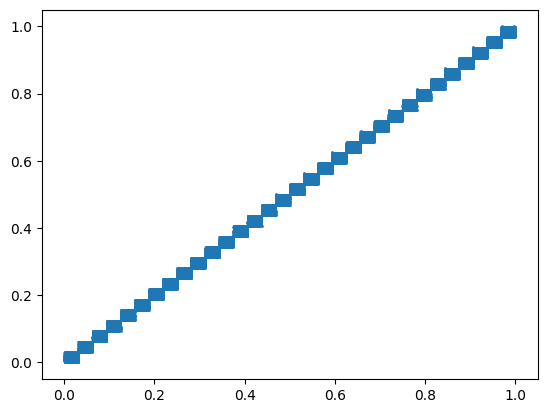

In [84]:
plt.scatter(s_sobol[2], s_sobol[3], 1)

In [77]:
print('sobol discrepancy:', discrepancy(s_sobol))
print('faure discrepancy:', discrepancy(s_faure))

sobol discrepancy: 5.021691549714213e-06
faure discrepancy: 2.928785065482198e-05
